# Identifying Entities in Healthcare Data



## Workspace set up: Import and Install useful packages.

In [1]:
# installing dependencies
# importing libraries

!pip install -U 'scikit-learn<0.24' sklearn-crfsuite pycrf nltk spacy pandas
!python -m spacy download en_core_web_sm

import spacy, nltk
import sklearn_crfsuite
from sklearn_crfsuite import metrics
from spacy.matcher import Matcher
from spacy.tokenizer import Tokenizer
from spacy.tokens import Token

Token.set_extension('noun_chunk', default=False)

     |████████████████████████████████| 13.9 MB 10.4 MB/s eta 0:00:01


✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [2]:
# downloading nltk data

nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package stopwords to /Users/apple/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/apple/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

## Data Preprocessing

The dataset provided is in the form of one word per line. Let's understand the format of data below:
- Suppose there are *x* words in a sentence, then there will be *x* continuous lines with one word in each line. 
- Further, the two sentences are separated by empty lines. The labels for the data follow the same format.

**We need to pre-process the data to recover the complete sentences and their labels.**


### Construct the proper sentences from individual words and print the 5 sentences.

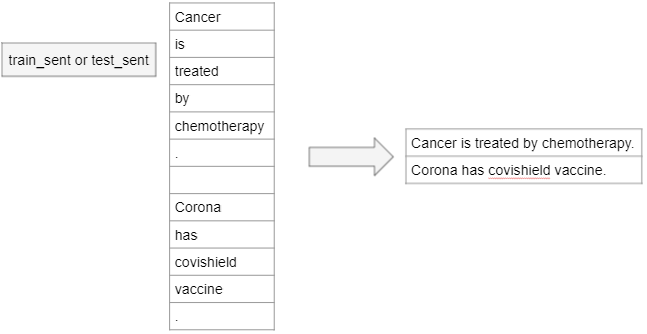

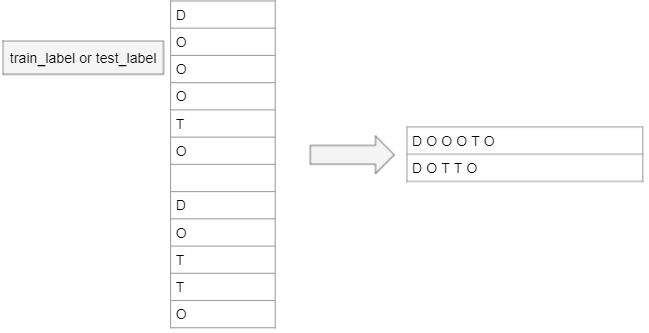

In [3]:
# Defining a function that will create a list of sentences from the data in the given format

def get_sentences(f:str):
    with open(f) as fobj:
        data = fobj.read().splitlines()
    sentences = []
    sentence = ""
    for x in data:
        if len(x.strip()) != 0:
            sentence += x
            sentence += " "
        else:
            sentences.append(sentence.strip())
            sentence = ""
    return sentences

In [4]:
# getting a list of training sentences and training labels from the data by using the function we ahve defined above

train_sent = get_sentences("./train_sent")
train_label = get_sentences("./train_label")

In [5]:
# getting a list of testing sentences and testing labels from the data by using the function we ahve defined above

test_sent = get_sentences("./test_sent")
test_label = get_sentences("./test_label")

In [6]:
# printing 5 sentences from train data to make sure the data is in correct format

train_sent[:5]

['All live births > or = 23 weeks at the University of Vermont in 1995 ( n = 2395 ) were retrospectively analyzed for delivery route , indication for cesarean , gestational age , parity , and practice group ( to reflect risk status )',
 'The total cesarean rate was 14.4 % ( 344 of 2395 ) , and the primary rate was 11.4 % ( 244 of 2144 )',
 'Abnormal presentation was the most common indication ( 25.6 % , 88 of 344 )',
 "The `` corrected '' cesarean rate ( maternal-fetal medicine and transported patients excluded ) was 12.4 % ( 273 of 2194 ) , and the `` corrected '' primary rate was 9.6 % ( 190 of 1975 )",
 "Arrest of dilation was the most common indication in both `` corrected '' subgroups ( 23.4 and 24.6 % , respectively )"]

In [7]:
# printing 5 labels from train data to make sure the data is in correct format

train_label[:5]

['O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O',
 'O O O O O O O O O O O O O O O O O O O O O O O O O',
 'O O O O O O O O O O O O O O O',
 'O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O',
 'O O O O O O O O O O O O O O O O O O O O O O']

In [8]:
# printing 5 sentences from test data to make sure the data is in correct format

train_sent[:5]

['All live births > or = 23 weeks at the University of Vermont in 1995 ( n = 2395 ) were retrospectively analyzed for delivery route , indication for cesarean , gestational age , parity , and practice group ( to reflect risk status )',
 'The total cesarean rate was 14.4 % ( 344 of 2395 ) , and the primary rate was 11.4 % ( 244 of 2144 )',
 'Abnormal presentation was the most common indication ( 25.6 % , 88 of 344 )',
 "The `` corrected '' cesarean rate ( maternal-fetal medicine and transported patients excluded ) was 12.4 % ( 273 of 2194 ) , and the `` corrected '' primary rate was 9.6 % ( 190 of 1975 )",
 "Arrest of dilation was the most common indication in both `` corrected '' subgroups ( 23.4 and 24.6 % , respectively )"]

In [9]:
# printing 5 labels from train data to make sure the data is in correct format

train_label[:5]

['O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O',
 'O O O O O O O O O O O O O O O O O O O O O O O O O',
 'O O O O O O O O O O O O O O O',
 'O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O',
 'O O O O O O O O O O O O O O O O O O O O O O']

### Count the number of sentences in the processed train and test dataset 

In [10]:
# count of train and test sentences

print("count of sentences in train dataset : ", len(train_sent))
print("count of sentences in test dataset : ", len(test_sent))

count of sentences in train dataset :  2599
count of sentences in test dataset :  1056


### Count the number of lines of labels in the processed train and test dataset.

In [11]:
# count of train and test labels

print("count of labels in train dataset : ", len(train_label))
print("count of labels in test dataset : ", len(test_label))

count of labels in train dataset :  2599
count of labels in test dataset :  1056


In [12]:
# initializing and getting english stopwords from nltk

from nltk.corpus import stopwords
stopwords = stopwords.words("english")

## Concept Identification

We will first explore what are the various concepts present in the dataset. For this, we will use PoS Tagging. 

### Extract those tokens which have NOUN or PROPN as their PoS tag and find their frequency

In [13]:
import re
freq = {}
freq2 = {}
nlp = spacy.load("en_core_web_sm", disable=['ner'])

# we are using the custom tokenizer that uses the basic string.split.
nlp.tokenizer = Tokenizer(nlp.vocab)

for x in test_sent:
    doc = nlp(x)
    for y in doc:
        if y.pos_ in ["NOUN","PROPN"] and y.text.lower() not in stopwords and re.match("\w+", y.text):
            freq[y.text.lower()] = freq.get(y.text,0)+1
    for np in doc.noun_chunks:
        freq2[np.text.lower()] = freq2.get(np.text,0)+1
    

for x in train_sent:
    doc = nlp(x)
    for y in doc:
        if y.pos_ in ["NOUN","PROPN"] and y.text.lower() not in stopwords and re.match("\w+", y.text):
            freq[y.text.lower()]  = freq.get(y.text,0)+1
    for np in doc.noun_chunks:
        freq2[np.text.lower()] = freq2.get(np.text,0)+1
        

### Print the top 25 most common tokens with NOUN or PROPN PoS tags

In [14]:
from collections import Counter
count = Counter(freq)
count.most_common(25)

[('cancer', 89),
 ('lung', 80),
 ('cells', 61),
 ('response', 60),
 ('years', 56),
 ('protein', 54),
 ('age', 52),
 ('activity', 52),
 ('carcinoma', 51),
 ('combination', 46),
 ('cell', 44),
 ('survival', 43),
 ('months', 41),
 ('failure', 40),
 ('weeks', 37),
 ('hepatitis', 37),
 ('patients', 36),
 ('mg', 36),
 ('time', 36),
 ('groups', 34),
 ('tumors', 34),
 ('infarction', 33),
 ('asthma', 33),
 ('vaccine', 32),
 ('pregnancy', 31)]

### Print the top 25 most common noun phrases

In [15]:
# lets try and check the most common noun phrases
count2 = Counter(freq2)
count2.most_common(25)

[('that', 113),
 ('which', 77),
 ('the treatment', 56),
 ('patients', 26),
 ('who', 25),
 ('pregnancy', 24),
 ('those', 20),
 ('age', 20),
 ('children', 19),
 ('survival', 19),
 ('combination', 19),
 ('they', 18),
 ('brief', 17),
 ('preeclampsia', 16),
 ('cisplatin', 16),
 ('mice', 15),
 ('acute myocardial infarction', 14),
 ('asthma', 14),
 ('duration', 13),
 ('the patients', 13),
 ('adults', 13),
 ('men', 13),
 ('addition', 12),
 ('the management', 12),
 ('nsclc', 12)]

## Defining features for CRF


In [19]:
# function to view the sentence and corresponding pos, dep, label for the word

def view_sentence(s, l):
    toks = l.split()
    doc = nlp(s)
    for i, y in enumerate(doc):
        print(y.text + " -- " + y.pos_+ " -- " + y.dep_+ " -- " + toks[i])

In [20]:
n=0
def view_entity_sents():
    global n
    print(n)
    for k in range(n, len(train_sent)):    
        if "D" in train_label[k]:
            n = k+1
            yield view_sentence(train_sent[k], train_label[k])

In [21]:
# viewing the sentences to understand the context in which diagnosis and treatment occour

next(view_entity_sents())

0
The -- DET -- det -- O
study -- NOUN -- compound -- O
population -- NOUN -- nsubj -- O
included -- VERB -- ROOT -- O
84 -- NUM -- nummod -- O
women -- NOUN -- dobj -- O
with -- ADP -- prep -- O
gestational -- ADJ -- amod -- D
diabetes -- NOUN -- pobj -- D
, -- PUNCT -- punct -- O
ascertained -- VERB -- advcl -- O
by -- ADP -- agent -- O
universal -- ADJ -- amod -- O
screening -- NOUN -- pobj -- O
of -- ADP -- prep -- O
all -- DET -- det -- O
women -- NOUN -- pobj -- O
attending -- VERB -- acl -- O
the -- DET -- det -- O
antenatal -- ADJ -- amod -- O
clinic -- NOUN -- dobj -- O
of -- ADP -- prep -- O
the -- DET -- det -- O
Hadassah -- PROPN -- compound -- O
Medical -- PROPN -- compound -- O
Center -- PROPN -- pobj -- O
, -- PUNCT -- punct -- O
over -- ADP -- prep -- O
a -- DET -- det -- O
2-year -- NUM -- amod -- O
period -- NOUN -- pobj -- O


In [22]:
# function helpful in saving the data as word(tag) word(tag) format
# so that we can easily review the functions

def get_as_text(f_data,f_label):
    with open(f_data) as fobj:
        data = fobj.read().splitlines()
    with open(f_label) as fobj:
        labels = fobj.read().splitlines()
    sentences = []
    sentence = ""
    for i, x in enumerate(data):
        if len(x.strip()) != 0:
            sentence += x
            sentence += "("+labels[i]+")"
            sentence += " "
        else:
            sentences.append(sentence.strip())
            sentence = ""
    return sentences

In [23]:
# saving the test and train data in right format so we can view the data

sents = get_as_text("./test_sent","./test_label")
with open("content_text.txt","w") as fobj:
    fobj.write("\n\n".join(sents))

sents = get_as_text("./train_sent","./train_label")
with open("content.txt","w") as fobj:
    fobj.write("\n\n".join(sents))

### Feature List

Based on several data observations of pos tags and dependency tags for Treatment entites.<br>
> for the current word: 
1. input word in lower case
2. weather word starts with capital letter
3. weather the word is stop word
4. weather the word is oov
5. dependency tag of the word
6. pos tag of the word
7. weather the word is a part of a noun chunk or not
8. weather the word is at begining or at the end

> for the next word:
1. next word in lower case
2. weather next word starts with capital letter
3. dependency tag of next word
4. pos tag of next word
5. weather next word is a part of a noun chunk or not

> for the previous word
1. previous word in lower case
2. weather previous word starts with capital letter
3. dependency tag of previous word
4. pos tag of previous word
5. weather previous word is a part of a noun chunk or not

## Getting the features

### Write a code/function to get the features for a sentence


In [24]:
#Define a function to get the above defined features for a word.

def getFeaturesForOneWord(words, i):
  word = words[i]

  features = [
    'word.lower=' + word.text.lower(),
    'word.startsWithCapital=%s' % word.text[0].isupper(),
    'word.stop=%s' % word.is_stop or word.is_punct,
    'word.oov=%s' % word.is_oov,
    'word.dep=' + word.dep_,
    'word.depstart=' + word.dep_[:3],
    'word.nounChunk=%s'% word._.noun_chunk,
    'word.nounChunkStart=%s'% word._.noun_chunk,
    'word.pos=' + word.pos_,
    'word.posstart=' + word.pos_[:2],
  ]

  if(i > 0):
    prev_word = words[i-1]
    features.extend([
    'prev_word.lower=' + prev_word.text.lower(), 
    'prev_word.startsWithCapital=%s' % prev_word.text[0].isupper(),
    'prev_word.dep=' + prev_word.dep_,
    'prev_word.depstart=' + prev_word.dep_[:3],
    'prev_word.nounChunk=%s'% prev_word._.noun_chunk,
    'prev_word.pos=' + prev_word.pos_,
    'prev_word.posstart=' + prev_word.pos_[:2]
  ])
  else:
    features.append('BEG') 
    
  if(i < len(words)-1):
    next_word = words[i+1]
    features.extend([
    'next_word.lower=' + next_word.text.lower(), 
    'next_word.startsWithCapital=%s' % next_word.text[0].isupper(),
    'next_word.dep=' + next_word.dep_,
    'next_word.depstart=' + next_word.dep_[:3],
    'next_word.nounChunk=%s'% next_word._.noun_chunk,
    'next_word.pos=' + next_word.pos_,
    'next_word.posstart=' + next_word.pos_[:2]
  ]) 
  else:
    features.append('END')

  return features

In [25]:
# Define a function to get features for a sentence 
# using the 'getFeaturesForOneWord' function.

def getFeaturesForOneSentence(sentence):
  sentence_list = nlp(sentence)
  for noun_chunk in sentence_list.noun_chunks:
    for token in noun_chunk:
        if len(noun_chunk) > 0:
            token._.noun_chunk = True
  return [getFeaturesForOneWord(sentence_list, pos) for pos in range(len(sentence_list))]

In [26]:
# Apply function 'getFeaturesForOneSentence' to get features on a single 
# sentence which is at index value 5 in train_sentences

i = 5
example_sentence = train_sent[i]
print(example_sentence)
print(train_label[i])

features = getFeaturesForOneSentence(example_sentence)
features[0]

Cesarean rates at tertiary care hospitals should be compared with rates at community hospitals only after correcting for dissimilar patient groups or gestational age
O O O O O O O O O O O O O O O O O O O O O O O O


['word.lower=cesarean',
 'word.startsWithCapital=True',
 'word.stop=False',
 'word.oov=True',
 'word.dep=amod',
 'word.depstart=amo',
 'word.nounChunk=True',
 'word.nounChunkStart=True',
 'word.pos=ADJ',
 'word.posstart=AD',
 'BEG',
 'next_word.lower=rates',
 'next_word.startsWithCapital=False',
 'next_word.dep=nsubjpass',
 'next_word.depstart=nsu',
 'next_word.nounChunk=True',
 'next_word.pos=NOUN',
 'next_word.posstart=NO']

### Write a code/function to get the labels of a sentence

In [27]:
# Define a function to get the labels for a sentence.

def getLabelsInListForOneSentence(labels):
  return labels.split()

## Define input and target variables for train and test dataset

In [28]:
# creating train, validation and test data and corresponding label data

from sklearn.model_selection import train_test_split

X = [getFeaturesForOneSentence(sentence) for sentence in train_sent]
Y = [getLabelsInListForOneSentence(labels) for labels in train_label]

X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2)

X_test = [getFeaturesForOneSentence(sentence) for sentence in test_sent]
Y_test = [getLabelsInListForOneSentence(labels) for labels in test_label]

## Build the CRF Model

In [29]:
# Build the CRF model.

crf = sklearn_crfsuite.CRF( keep_tempfiles=None,
                            algorithm='lbfgs',
                            c1=0.1,
                            c2=0.1,
                            max_iterations=100,
                            all_possible_transitions=True)
crf.fit(X_train, Y_train)

/opt/anaconda3/envs/upgrad/lib/python3.8/site-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


CRF(algorithm='lbfgs', all_possible_transitions=True, c1=0.1, c2=0.1,
    keep_tempfiles=None, max_iterations=100)

In [30]:
# predicting the values with the best predictor
Y_val_pred = crf.predict(X_val)

In [31]:
# Calculate the f1 score using the test data

labels = list(crf.classes_)
sorted_labels = sorted(
    labels,
    key=lambda name: (name[1:], name[0])
)
print(metrics.flat_classification_report(
    Y_val, Y_val_pred, labels=sorted_labels, digits=3
))

              precision    recall  f1-score   support

           D      0.830     0.610     0.703       707
           O      0.918     0.979     0.948      7639
           T      0.738     0.369     0.492       642

    accuracy                          0.907      8988
   macro avg      0.829     0.653     0.714      8988
weighted avg      0.899     0.907     0.896      8988



/opt/anaconda3/envs/upgrad/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass labels=['D', 'O', 'T'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


In [32]:
# printing the validation score

metrics.flat_f1_score(Y_val, Y_val_pred, average='weighted')

0.8960679596016782

In [33]:
# Hyper parameter tuning using random search CV

import scipy
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer

crf2 = sklearn_crfsuite.CRF(keep_tempfiles=None,
                            algorithm='lbfgs',
                            max_iterations=100,
                            all_possible_transitions=True)

params_space = {
    'c1': scipy.stats.expon(scale=0.5),
    'c2': scipy.stats.expon(scale=0.05)
}

# use the same metric for evaluation
f1_scorer = make_scorer(metrics.flat_f1_score,
                        average='weighted', labels=['O','D','T'])

# search
rs = RandomizedSearchCV(crf2, params_space,
                        cv=5,
                        verbose=1,
                        n_jobs=-1,
                        n_iter=15,
                        scoring=f1_scorer)
rs.fit(X, Y)

Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:  4.2min finished


RandomizedSearchCV(cv=5,
                   estimator=CRF(algorithm='lbfgs',
                                 all_possible_transitions=True,
                                 keep_tempfiles=None, max_iterations=100),
                   n_iter=15, n_jobs=-1,
                   param_distributions={'c1': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f928681cf70>,
                                        'c2': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f92843f8730>},
                   scoring=make_scorer(flat_f1_score, average=weighted, labels=['O', 'D', 'T']),
                   verbose=1)

In [34]:
# Calculate the f1 score using the test data

Y_pred = rs.best_estimator_.predict(X_test)
labels = list(rs.best_estimator_.classes_)
sorted_labels = sorted(
    labels,
    key=lambda name: (name[1:], name[0])
)
print(metrics.flat_classification_report(
    Y_test, Y_pred, labels=sorted_labels, digits=3
))

              precision    recall  f1-score   support

           D      0.827     0.599     0.694      1450
           O      0.939     0.978     0.958     16127
           T      0.751     0.552     0.636      1041

    accuracy                          0.925     18618
   macro avg      0.839     0.710     0.763     18618
weighted avg      0.920     0.925     0.920     18618



In [35]:
# printing the validation score and best hyper parameters of the random search cv

print(metrics.flat_f1_score(Y_test, Y_pred, average='weighted'))
print(rs.best_estimator_)

0.9197528864438721
CRF(algorithm='lbfgs', all_possible_transitions=True, c1=0.008582690453911196,
    c2=0.07236665832785741, keep_tempfiles=None, max_iterations=100)


In [36]:
# predicting the values with the best predictor

Y_pred = rs.best_estimator_.predict(X_test)

In [37]:
# Print the orginal labels and predicted labels for the sentence in test data, which is at index value 46.

id = 46
print("Sentence:",test_sent[id])
print("Orig Labels:", Y_test[id])
print("Pred Labels:", Y_pred[id])

Sentence: < TO_SEE > CONTEXT : There is a substantial risk of a second cancer for persons with hereditary retinoblastoma , which is enhanced by radiotherapy
Orig Labels: ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Pred Labels: ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'D', 'O', 'O', 'O', 'O', 'O', 'T']


### Create the logic to get all the predicted treatments (T) labels corresponding to each disease (D) label in the test dataset.

In [38]:
map = {}
import pdb


# this function only extracts words not very accurate
# for i, x in enumerate(Y_pred):
#     if 'D' in x and 'T' in x:
        # prev = "O"
        # diag = ""
        # treat = ""
        # for j, y in enumerate(Y_pred[i]):
        #     if y == "D" and prev == 'D':
        #         diag += test_sent[i].split()[j]
        #         diag += " "
        #     elif y == "T" and prev == 'T':
        #         treat += test_sent[i].split()[j]
        #         treat += " "
        #     else:
        #         prev = y
        # if len(diag.strip()) > 0 and len(treat.strip()) > 0:
        #     print("Diagnosis " + diag + " Treatment " + treat)
        #     map[diag] = treat


# if a diagnosis or treatment is part of noun chunk, below function extracts
# entire noun chunk a instead of pirticular word.

for i, x in enumerate(Y_pred):
    if 'D' in x and 'T' in x:
        doc = nlp(test_sent[i])
        for noun_chunk in doc.noun_chunks:
            for token in noun_chunk:
                token._.noun_chunk = noun_chunk
        prev = "O"
        diags = []
        diag = ""
        treat = ""
        for j, y in enumerate(Y_pred[i]):
            if y == "D":
                if doc[j]._.noun_chunk and doc[j].text not in diag:
                    diag += doc[j]._.noun_chunk.text
                    diag += " "
                elif doc[j].text not in diag:
                    diag += test_sent[i].split()[j]
                    diag += " "
            elif y == "T":
                if doc[j]._.noun_chunk and doc[j].text not in treat:
                    treat += doc[j]._.noun_chunk.text
                    treat += " "
                elif doc[j].text not in treat:
                    treat += test_sent[i].split()[j]
                    treat += " "
            elif y == "O":
                if prev == "D":
                    diags.append(diag)
                    diag = ""
                elif prev == "T":
                    for d in diags:
                        if d in map.keys():
                            map[d] = map[d] + ", " + treat
                        else:
                            map[d] = treat
                    diags = []
                else:
                    diag = ""
            prev = y
        if (len(diag.strip()) > 0 or len(diags) > 0) and len(treat.strip()) > 0:
            if len(diag.strip()) > 0:
                diags.append(diag)
            for d in diags:
                if d in map.keys():
                    map[d] = map[d] + ", " + treat
                else:
                    map[d] = treat

In [39]:
import pandas as pd
pd.DataFrame(map.keys(), map.values())

,0
good glycemic control,macrosomic infants gestational diabetes cases
radiotherapy,hereditary retinoblastoma
Methylphenidate,epilepsy
Methylphenidate,ADHD
roxithromycin,unstable angina or non-Q-wave myocardial infar...
...,...
vaccines,pertussis
sumatriptan,migraine
Surgical management,severe secondary peritonitis
Hepatic arterial infusion of chemotherapy,hepatic metastases from colorectal cancer


### Predict the treatment for the disease name: 'hereditary retinoblastoma'

In [41]:
for x in map.keys():
    if "retinoblastoma" in x:
        print("the treatment for hereditary retinoblastoma is", map[x] )

the treatment for hereditary retinoblastoma is radiotherapy 
